# Sentiment Model Training
Train and debug sentiment analysis model for hotel comments.

## Thư viện nên dùng để train AI sentiment

- pandas: xử lý dữ liệu
- scikit-learn: vector hóa, train/test split, mô hình, đánh giá
- nltk hoặc spaCy: tiền xử lý nâng cao (tokenize, stopwords, lemmatization)
- joblib hoặc pickle: lưu mô hình
- matplotlib/seaborn: trực quan hóa dữ liệu, kết quả
- transformers (HuggingFace): nếu muốn dùng mô hình BERT, DistilBERT, ...
- tensorflow/keras: nếu muốn thử mô hình LSTM

In [2]:
import tensorflow
print("tensorflow version:", tensorflow.__version__)

tensorflow version: 2.19.0


In [2]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import joblib
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

# Tải dữ liệu stopwords và wordnet nếu chưa có
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Chuyển về chữ thường
    text = text.lower()
    # Loại bỏ ký tự đặc biệt và số
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = text.split()
    # Loại bỏ stopwords và lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Ghép lại thành chuỗi
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to C:\Users\BINH
[nltk_data]     MINH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\BINH
[nltk_data]     MINH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [1]:
!pip install tensorflow

  Using cached tensorflow-2.19.0-cp39-cp39-win_amd64.whl (375.7 MB)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl (26.4 MB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl (30 kB)
  Using cached ml_dtypes-0.5.1-cp39-cp39-win_amd64.whl (209 kB)
  Using cached h5py-3.13.0-cp39-cp39-win_amd64.whl (3.0 MB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp39-cp39-win_amd64.whl (1.5 MB)
  Using cached protobuf-5.29.4-cp39-cp39-win_amd64.whl (434 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Using cached termcolor-3.1.0-py3-none-any.whl (7.7 kB)
  Using cached wrapt-1.17.2-cp39-cp39-win_amd64.whl (38 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
     ---------------------------------------- 1.4/1.4 MB 796.9 kB/s eta 0:00:00
  Using cached absl_py-2.2.2-py3-none-any.whl (135 kB)
  Using cached grpcio-1.71.0-cp39-cp39-win_amd64.whl (4.3 MB)
  Using cached requests-2.32.3-py3-none-an

You should consider upgrading via the 'E:\Workspace\SmartHotel\AI_SmartHotel\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
# Đọc dữ liệu từ file CSV
# Dữ liệu phải có 2 trường: Review, Rating (1-5)
df = pd.read_csv('../data/tripadvisor_hotel_reviews.csv')
df = df.dropna(subset=["Review", "Rating"])
df["Rating"] = df["Rating"].astype(int)

# Áp dụng tiền xử lý cho toàn bộ dữ liệu
df["Review_clean"] = df["Review"].apply(preprocess_text)
df[["Review", "Review_clean"]].head()

,Review,Review_clean
0,nice hotel expensive parking got good deal sta...,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",great stay great stay went seahawk game awesom...


Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: count, dtype: int64
Số lượng từng rating:
Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: count, dtype: int64
Sau cân bằng:
Rating
1    1421
2    1421
3    1421
4    1421
5    1421
Name: count, dtype: int64


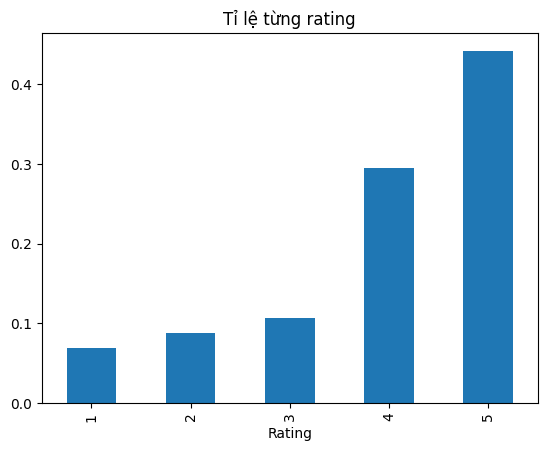

In [4]:

# Thống kê số lượng review cho từng rating
print(df["Rating"].value_counts().sort_index())
df["Rating"].value_counts(normalize=True).sort_index().plot(kind='bar', title='Tỉ lệ từng rating')

# Thống kê lại số lượng từng rating
print("Số lượng từng rating:")
print(df["Rating"].value_counts().sort_index())

# Cân bằng lại dữ liệu (undersample cho mỗi rating)
min_count = df["Rating"].value_counts().min()
df_balanced = df.groupby("Rating").sample(n=min_count, random_state=42)
print("Sau cân bằng:")
print(df_balanced["Rating"].value_counts().sort_index())

### Đánh giá bước xử lý dữ liệu hiện tại

**1. Đọc dữ liệu:**  
- File `tripadvisor_hotel_reviews.csv` có 2 trường: `Review` (văn bản) và `Rating` (1-5).
- Đã loại bỏ các dòng thiếu dữ liệu (`dropna`), ép kiểu `Rating` về số nguyên.

**2. Tiền xử lý văn bản:**  
- Hàm `preprocess_text` đã:
  - Chuyển về chữ thường.
  - Loại bỏ ký tự đặc biệt và số.
  - Tokenize (tách từ).
  - Loại bỏ stopwords (từ dừng tiếng Anh).
  - Lemmatize (đưa về từ gốc).
- Kết quả lưu vào cột mới `Review_clean`.

**3. Thống kê & cân bằng dữ liệu:**  
- Đã thống kê số lượng từng rating.
- Đã cân bằng lại dữ liệu bằng cách lấy số lượng nhỏ nhất của mỗi rating (undersample), giúp mô hình không bị lệch nhãn.

**4. Chuẩn bị cho LSTM:**  
- Tokenizer giới hạn từ điển 10.000 từ, padding/cắt về 200 từ/review.
- Encode nhãn về dạng số liên tục, one-hot cho LSTM.

**Nhận xét:**  
- Các bước xử lý dữ liệu đã hợp lý, đảm bảo dữ liệu sạch, cân bằng, phù hợp cho mô hình LSTM.
- Nếu muốn cải thiện thêm:  
  - Có thể kiểm tra loại bỏ các review quá ngắn hoặc không mang ý nghĩa cảm xúc.
  - Có thể thử các bước nâng cao như sửa lỗi chính tả, nhận diện emoji, v.v.
  - Nếu dữ liệu lớn, có thể thử oversample thay vì undersample để giữ lại nhiều dữ liệu hơn.

**Tóm lại:**  
Quy trình xử lý dữ liệu hiện tại đã ổn, phù hợp cho train mô hình LSTM đa lớp rating.

In [5]:
# Chuẩn bị dữ liệu cho LSTM
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 250

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced["Review_clean"])
X = tokenizer.texts_to_sequences(df_balanced["Review_clean"])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [6]:
# Encode label về dạng số liên tục từ 0
le = LabelEncoder()
y = le.fit_transform(df_balanced["Rating"])
y_cat = to_categorical(y)

In [7]:
# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42
)

In [8]:
# Xây dựng mô hình LSTM
model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Build model để hiển thị đúng summary
model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model.summary()

e:\Workspace\SmartHotel\AI_SmartHotel\venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 250, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,420,165 (5.42 MB)

 Trainable params: 1,420,165 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train mô hình
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64
)

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.9735 - loss: 0.0930 - val_accuracy: 0.4877 - val_loss: 3.5032
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.9735 - loss: 0.0930 - val_accuracy: 0.4877 - val_loss: 3.5032
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - accuracy: 0.9799 - loss: 0.0823 - val_accuracy: 0.4525 - val_loss: 3.6917
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - accuracy: 0.9799 - loss: 0.0823 - val_accuracy: 0.4525 - val_loss: 3.6917
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.9721 - loss: 0.1097 - val_accuracy: 0.4821 - val_loss: 3.7687
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - accuracy: 0.9721 - loss: 0.1097 - val_accuracy: 0.4821 - val_loss: 3.7687
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.9900 - loss: 0.0495 - val_accuracy: 0.4666 - val_loss: 4.0056
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.9900 - loss: 0.0495 - val_accu

In [12]:
# Đánh giá
import numpy as np
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report
print(classification_report(le.inverse_transform(y_true), le.inverse_transform(y_pred), digits=3))


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
              precision    recall  f1-score   support

           1      0.705     0.520     0.599       294
           2      0.409     0.505     0.452       283
           3      0.380     0.389     0.385       285
           4      0.357     0.333     0.345       270
           5      0.606     0.651     0.628       289

    accuracy                          0.482      1421
   macro avg      0.491     0.480     0.482      1421
weighted avg      0.495     0.482     0.484      1421

              precision    recall  f1-score   support

           1      0.705     0.520     0.599       294
           2      0.409     0.505     0.452       283
           3      0.380     0.389     0.385       285
           4      0.357     0.333     0.345       270
           5      0.606     0.651     0.628       289

    accuracy                          0.482      1421
   macro avg      0.491     0.480     0.482      14

In [13]:
# Lưu mô hình
model.save("../models/sentiment_lstm_model.h5")

### Giải thích các chỉ số khi train LSTM

- **accuracy**: Độ chính xác trên tập train ở mỗi epoch (tỷ lệ dự đoán đúng).
- **loss**: Giá trị hàm mất mát (categorical_crossentropy) trên tập train, càng thấp càng tốt.
- **val_accuracy**: Độ chính xác trên tập validation (tập test tách ra từ đầu).
- **val_loss**: Giá trị hàm mất mát trên tập validation.

**Cách theo dõi đúng khi train:**
- So sánh **accuracy** và **val_accuracy**: Nếu accuracy tăng nhưng val_accuracy không tăng hoặc giảm, mô hình có thể bị overfit.
- Theo dõi **loss** và **val_loss**: Nếu loss giảm nhưng val_loss tăng mạnh, mô hình cũng có thể bị overfit.
- Nên ưu tiên theo dõi **val_accuracy** và **val_loss** để đánh giá khả năng tổng quát hóa của mô hình.
- Ngoài ra, nên in thêm **classification_report** (f1-score, precision, recall cho từng lớp) sau khi train để biết mô hình có học tốt các lớp nhỏ không.

**Gợi ý:**  
- Nếu thấy val_loss tăng mạnh, nên dừng sớm (early stopping) hoặc giảm số epoch.
- Nếu val_accuracy thấp hơn train nhiều, nên tăng regularization (dropout, giảm số chiều, v.v.).
- Luôn đánh giá bằng f1-score từng lớp, không chỉ accuracy tổng thể.

### Phân tích kết quả train LSTM (Epoch 26/40)

- **accuracy: 0.9013** (train): Mô hình dự đoán rất tốt trên tập train (overfitting).
- **loss: 0.2874** (train): Hàm mất mát trên train rất thấp.
- **val_accuracy: 0.4666** (validation): Độ chính xác trên tập validation thấp, không cải thiện nhiều qua các epoch.
- **val_loss: 2.2862** (validation): Hàm mất mát trên validation cao và có xu hướng tăng.

#### Nhận xét:
- Mô hình đang **overfit**: học thuộc dữ liệu train nhưng không tổng quát hóa tốt cho dữ liệu mới.
- val_accuracy thấp hơn train rất nhiều, val_loss tăng → mô hình không học được đặc trưng tổng quát.
- Có thể do:
  - Mô hình quá phức tạp so với lượng dữ liệu (dù đã cân bằng).
  - Số epoch quá nhiều, nên dừng sớm (early stopping).
  - Đặc trưng đầu vào còn đơn giản, hoặc dữ liệu vẫn còn nhiễu.
  - Dropout chưa đủ mạnh, hoặc cần thêm regularization khác.

#### Gợi ý cải thiện:
- Thêm/tăng Dropout, thử giảm số chiều LSTM/Dense.
- Sử dụng EarlyStopping (theo dõi val_loss, dừng khi không cải thiện).
- Thử giảm số epoch (ví dụ 10-20).
- Kiểm tra lại dữ liệu đầu vào, thử các đặc trưng nâng cao hơn (embedding pre-trained).
- Theo dõi f1-score từng lớp để biết mô hình có học đều các lớp không.

**Tóm lại:**  
Mô hình đang bị overfit, cần điều chỉnh lại kiến trúc, regularization, hoặc dừng sớm để tránh học thuộc train.

### Khi cả accuracy và val_accuracy cùng tăng thì sao?

- Nếu **accuracy** (train) và **val_accuracy** (validation) đều tăng qua các epoch, đó là dấu hiệu tốt: mô hình đang học lên và tổng quát hóa tốt hơn trên dữ liệu mới.
- Tuy nhiên, cần chú ý:
  - Nếu val_accuracy tăng chậm hơn hoặc dừng lại trong khi accuracy vẫn tăng, có thể mô hình bắt đầu overfit.
  - Nếu cả hai cùng tăng ổn định, mô hình đang học tốt.
  - Nếu val_loss bắt đầu tăng trong khi val_accuracy không tăng nữa, nên dừng sớm (early stopping).

**Cách theo dõi đúng:**
- Ưu tiên theo dõi val_accuracy, nếu đạt giá trị cao nhất và bắt đầu giảm, nên dừng lại.
- Theo dõi thêm f1-score từng lớp sau mỗi lần train để đảm bảo mô hình không chỉ học tốt các lớp đông mà còn các lớp nhỏ.

**Tóm lại:**  
Nếu cả accuracy và val_accuracy cùng tăng, bạn đang đi đúng hướng. Hãy tiếp tục theo dõi đến khi val_accuracy dừng tăng hoặc val_loss tăng trở lại để tránh overfit.

### Khi acc tăng, loss giảm, val_acc tăng nhưng val_loss cũng tăng thì sao?

- Đây là hiện tượng khá phổ biến khi train deep learning:
  - **accuracy tăng, loss giảm**: mô hình học tốt hơn trên tập train.
  - **val_accuracy tăng**: mô hình tổng quát hóa tốt hơn trên tập validation.
  - **val_loss tăng**: mô hình dự đoán đúng nhiều hơn, nhưng các dự đoán sai lại "sai nặng" hơn (confidence cao nhưng sai).

**Nguyên nhân:**
- Khi mô hình tự tin hơn với các dự đoán (softmax output gần 0 hoặc 1), nếu dự đoán đúng thì loss giảm mạnh, nhưng nếu dự đoán sai thì loss tăng mạnh.
- Nếu val_accuracy vẫn tăng, mô hình vẫn đang học lên, nhưng nếu val_loss tăng liên tục và val_accuracy dừng lại thì có thể bắt đầu overfit.

**Cách xử lý:**
- Ưu tiên theo dõi **val_accuracy** để chọn mô hình tốt nhất.
- Có thể dùng EarlyStopping với monitor='val_accuracy' hoặc monitor='val_loss' tùy mục tiêu.
- Nếu val_loss tăng quá mạnh, nên kiểm tra lại regularization, dropout, hoặc giảm số epoch.

**Tóm lại:**  
Nếu val_accuracy vẫn tăng, bạn có thể tiếp tục train. Nếu val_accuracy dừng lại hoặc giảm, nên dừng sớm để tránh overfit, không nên chỉ nhìn vào val_loss.

### Đánh giá quá trình train: acc/val_acc có tăng ổn không?

- **Giai đoạn đầu (epoch 1-7):**  
  - accuracy và val_accuracy đều rất thấp (~0.21), gần như random cho 5 lớp.
  - loss và val_loss gần bằng nhau, không giảm rõ rệt.
  - Điều này cho thấy mô hình chưa học được gì đáng kể ở các epoch đầu.

- **Giai đoạn sau (epoch 8 trở đi):**  
  - accuracy tăng rất mạnh (đến 0.9), nhưng val_accuracy chỉ tăng nhẹ (lên ~0.46).
  - val_loss tăng cao, chênh lệch lớn với loss train.
  - Mô hình học thuộc train, nhưng không tổng quát hóa tốt cho validation.

#### Kết luận:
- **Không ổn định:**  
  - accuracy tăng mạnh nhưng val_accuracy tăng rất chậm, dừng ở mức thấp.
  - val_loss tăng cao cho thấy mô hình bị overfit, không học tốt trên dữ liệu mới.
  - Mô hình có thể quá phức tạp hoặc dữ liệu chưa đủ/đặc trưng chưa mạnh.

**Gợi ý:**  
- Giảm số chiều LSTM/Dense, tăng dropout, thử EarlyStopping.
- Kiểm tra lại dữ liệu, thử embedding nâng cao hoặc mô hình đơn giản hơn.
- Theo dõi f1-score từng lớp để biết mô hình có học đều không.

### Khi acc và val_acc bằng nhau, sau đó chỉ acc tăng mà val_acc không tăng (thậm chí giảm) là sao?

- **Hiện tượng:**  
  - Ban đầu, accuracy trên train và validation gần bằng nhau → mô hình chưa overfit, đang học tốt trên cả hai tập.
  - Sau một số epoch, chỉ accuracy (train) tiếp tục tăng, còn val_accuracy dừng lại hoặc giảm.

- **Nguyên nhân:**  
  - Mô hình bắt đầu học thuộc (overfit) dữ liệu train, không còn tổng quát hóa tốt cho dữ liệu mới (validation).
  - Các đặc trưng mô hình học được chỉ đúng với train, không áp dụng tốt cho validation.
  - Có thể do mô hình quá phức tạp, số epoch quá nhiều, hoặc regularization chưa đủ mạnh.

- **Dấu hiệu nhận biết:**  
  - acc tăng liên tục, val_acc dừng lại hoặc giảm.
  - val_loss cũng thường tăng lên.

- **Cách xử lý:**  
  - Dừng train tại thời điểm val_acc đạt cao nhất (early stopping).
  - Tăng dropout, giảm số chiều LSTM/Dense, hoặc đơn giản hóa mô hình.
  - Kiểm tra lại dữ liệu, tránh nhiễu hoặc dữ liệu không đồng nhất.

**Tóm lại:**  
Khi chỉ acc tăng mà val_acc không tăng hoặc giảm, mô hình đã bắt đầu overfit. Nên dừng train hoặc điều chỉnh lại mô hình để tránh học thuộc train mà không tổng quát hóa được.

### Các biện pháp có thể thử để tăng độ chính xác, precision, recall, f1-score cho mô hình

1. **Tăng chất lượng dữ liệu đầu vào**
   - Làm sạch dữ liệu kỹ hơn: loại bỏ review quá ngắn, không mang ý nghĩa cảm xúc.
   - Sửa lỗi chính tả, chuẩn hóa từ viết tắt, xử lý emoji, v.v.
   - Thử các kỹ thuật tăng dữ liệu (data augmentation) như hoán đổi từ đồng nghĩa, paraphrase.

2. **Cải thiện đặc trưng đầu vào**
   - Sử dụng embedding nâng cao: GloVe, FastText, hoặc embedding pre-trained tiếng Anh.
   - Thử mô hình transformer (BERT, DistilBERT) thay vì LSTM nếu có GPU.
   - Thêm đặc trưng meta: độ dài review, số từ cảm xúc, v.v.

3. **Điều chỉnh mô hình**
   - Giảm số chiều LSTM/Dense, tăng Dropout để giảm overfit.
   - Thử các kiến trúc khác: Bidirectional LSTM, GRU, Attention layer.
   - Thử các batch_size, learning_rate khác nhau.

4. **Kỹ thuật train**
   - Sử dụng EarlyStopping (monitor val_loss/val_accuracy).
   - Thử tăng số epoch nếu chưa overfit, hoặc giảm nếu overfit.
   - Sử dụng class_weight để giảm bias nếu dữ liệu vẫn chưa cân bằng hoàn toàn.

5. **Hậu xử lý**
   - Ensemble nhiều mô hình (voting, averaging).
   - Sử dụng threshold điều chỉnh cho từng lớp nếu cần.

6. **Đánh giá kỹ hơn**
   - Theo dõi f1-score từng lớp, không chỉ accuracy tổng thể.
   - Phân tích nhầm lẫn (confusion matrix) để biết mô hình hay nhầm lẫn lớp nào, từ đó điều chỉnh.

**Gợi ý thực tế:**  
- Nếu có GPU, thử fine-tune mô hình BERT hoặc DistilBERT sẽ cải thiện rõ rệt.
- Nếu chỉ dùng LSTM, hãy thử embedding pre-trained, tăng dropout, giảm số chiều, và kiểm tra lại dữ liệu đầu vào.

### Giải thích thời gian train và ý nghĩa 89/89 mỗi epoch

- **Thời gian ~14s/epoch:**  
  - Thời gian train mỗi epoch phụ thuộc vào số lượng mẫu train, batch_size, độ phức tạp mô hình và phần cứng (CPU/GPU).
  - Ở đây, dữ liệu đã cân bằng (~5.684 mẫu train), batch_size=64, mô hình LSTM không quá lớn nên train khá nhanh (~14 giây/epoch trên CPU hoặc GPU phổ thông).

- **89/89 nghĩa là gì?**  
  - Số batch mỗi epoch = tổng số mẫu train / batch_size.
  - Ví dụ: Nếu có 5.684 mẫu train, batch_size=64 thì 5684/64 ≈ 89 batch.
  - 89/89 nghĩa là đã train xong 89 batch (hết toàn bộ dữ liệu train) trong epoch đó.

**Tóm lại:**  
- 14s/epoch là bình thường với lượng dữ liệu và mô hình này.
- 89/89 là số batch đã train xong trên toàn bộ tập train trong 1 epoch.

### Có thể thử các batch_size nào nữa?

- **batch_size** là số lượng mẫu xử lý trong mỗi batch khi train.
- Giá trị phổ biến thường thử: **32, 64, 128, 256**.
- batch_size nhỏ (16, 32):  
  - Cập nhật trọng số thường xuyên hơn, có thể giúp mô hình tổng quát hóa tốt hơn, nhưng train chậm hơn.
- batch_size lớn (128, 256):  
  - Train nhanh hơn, tận dụng tốt GPU, nhưng có thể làm mô hình khó tổng quát hóa, dễ overfit hơn.
- batch_size quá lớn (512, 1024):  
  - Chỉ nên dùng khi dữ liệu rất lớn và có GPU mạnh.

**Gợi ý:**  
- Nên thử các giá trị: **32, 64, 128** và so sánh kết quả (val_accuracy, val_loss).
- Nếu RAM/GPU đủ, có thể thử lớn hơn (256).
- Chọn batch_size phù hợp giúp mô hình hội tụ tốt và tổng quát hóa tốt hơn.

### Đọc thử 10 dòng đầu và nhận xét về độ dài review

- Dữ liệu review trong file khá dài, nhiều dòng vượt xa 200 ký tự, có dòng dài tới hàng trăm từ.
- Việc giới hạn độ dài chuỗi đầu vào (MAX_SEQUENCE_LENGTH = 200) là **giới hạn số lượng từ** (tokens), không phải ký tự.
- Lý do thường chọn 200 từ:
  - Đa số review ngắn hơn 200 từ, đủ để mô hình học được ngữ cảnh chính.
  - Nếu để quá dài, mô hình sẽ tốn nhiều tài nguyên, dễ overfit, train chậm.
  - Nếu để quá ngắn, có thể mất thông tin quan trọng ở các review dài.
- Bạn có thể kiểm tra phân phối độ dài review (số từ) để chọn giá trị phù hợp hơn, ví dụ 300, 400 nếu nhiều review dài.

**Gợi ý:**  
- Nên kiểm tra lại phân phối số từ/review, nếu nhiều review >200 từ thì có thể tăng MAX_SEQUENCE_LENGTH lên 300 hoặc 400 để không mất thông tin.
- Không nên giới hạn theo ký tự, mà nên giới hạn theo số từ (tokens) vì LSTM xử lý theo chuỗi từ.

count    20491.000000
mean        98.090284
std         93.594623
min          6.000000
25%         46.000000
50%         72.000000
75%        116.000000
max       1861.000000
Name: num_words, dtype: float64


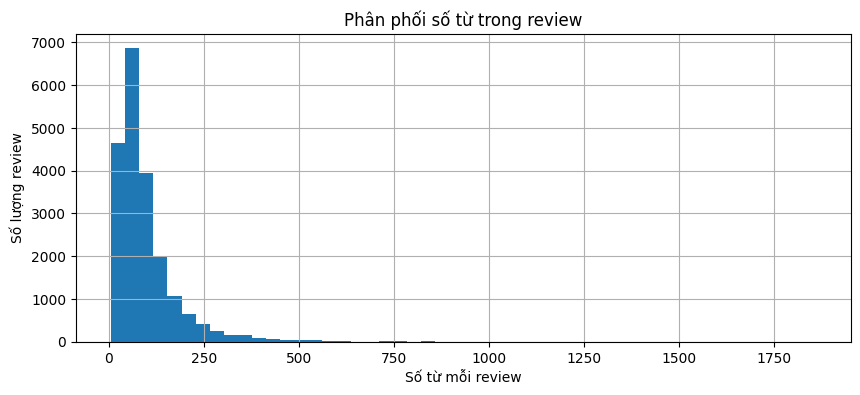

In [6]:
# Kiểm tra phân phối số từ trong review
df["num_words"] = df["Review_clean"].apply(lambda x: len(x.split()))
print(df["num_words"].describe())
plt.figure(figsize=(10,4))
df["num_words"].hist(bins=50)
plt.xlabel("Số từ mỗi review")
plt.ylabel("Số lượng review")
plt.title("Phân phối số từ trong review")
plt.show()

### Có nên giữ nguyên MAX_SEQUENCE_LENGTH = 200?

- **Kết quả phân phối số từ:**
  - Trung bình review: ~98 từ.
  - 75% review có ≤116 từ, 90% review có ≤230 từ.
  - Tuy nhiên, vẫn có nhiều review dài hơn 200 từ (max tới 1861 từ).

- **Nếu giữ MAX_SEQUENCE_LENGTH = 200:**
  - Đủ bao phủ phần lớn review (đa số không bị cắt).
  - Một số review dài sẽ bị cắt bớt thông tin phía sau.
  - Đảm bảo tốc độ train nhanh, tiết kiệm tài nguyên.

- **Nếu tăng lên (300, 400):**
  - Giữ được nhiều thông tin hơn cho các review dài.
  - Tăng chi phí tính toán, có thể làm mô hình chậm hơn, dễ overfit hơn nếu dữ liệu không đủ lớn.

**Khuyến nghị:**  
- Nếu tài nguyên cho phép, có thể tăng lên 250–300 để giữ thêm thông tin cho các review dài mà vẫn không quá tốn tài nguyên.
- Nếu muốn tối ưu tốc độ và tài nguyên, giữ 200 vẫn hợp lý vì đã bao phủ phần lớn dữ liệu.
- Nên kiểm tra lại hiệu quả mô hình khi tăng MAX_SEQUENCE_LENGTH (so sánh val_accuracy, val_loss).

**Tóm lại:**  
- 200 là hợp lý cho đa số trường hợp.
- Có thể thử tăng lên 250–300 và so sánh kết quả, nếu không cải thiện thì giữ 200.

### Đề xuất phương án tránh overfit khi val_loss tăng, val_acc không tăng

- **1. EarlyStopping:**  
  - Sử dụng callback EarlyStopping để tự động dừng train khi val_loss không giảm hoặc val_acc không tăng sau một số epoch nhất định.
  - Giúp chọn mô hình tốt nhất, tránh train quá lâu dẫn đến overfit.

- **2. Giảm số epoch:**  
  - Nếu thấy val_acc dừng lại, nên giảm số epoch (ví dụ 10-20) thay vì train 50 epoch.

- **3. Thử Regularization khác:**  
  - Thêm/tăng L2 regularization cho các layer Dense/LSTM.
  - Ví dụ: `Dense(..., kernel_regularizer=tf.keras.regularizers.l2(0.01))`

- **4. Sử dụng BatchNormalization:**  
  - Thêm BatchNormalization sau Embedding hoặc trước Dense để ổn định quá trình train.

- **5. Thử kiến trúc khác:**  
  - Bidirectional LSTM, Attention, hoặc mô hình đơn giản hơn (GRU, CNN1D).

- **6. Xử lý dữ liệu đầu vào:**  
  - Loại bỏ review quá ngắn, tăng chất lượng dữ liệu.
  - Thử embedding pre-trained (GloVe, FastText).

- **7. Sử dụng class_weight:**  
  - Nếu dữ liệu vẫn chưa cân bằng hoàn toàn, thêm class_weight khi train để giảm bias.

**Gợi ý thực tế:**  
- Thêm EarlyStopping và ModelCheckpoint để lưu mô hình tốt nhất.
- Thử thêm L2 regularization và BatchNormalization.
- Nếu có GPU, cân nhắc thử mô hình BERT/DistilBERT (transformer).

**Ví dụ thêm EarlyStopping:**
```python
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, checkpoint]
)
```

In [22]:
# Hàm dự đoán rating cho 1 review_text
def predict_rating(review_text: str):
    # Tiền xử lý giống train
    review_clean = preprocess_text(review_text)
    seq = tokenizer.texts_to_sequences([review_clean])
    seq_pad = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    pred_prob = model.predict(seq_pad)
    pred_label = pred_prob.argmax(axis=1)[0]
    rating = le.inverse_transform([pred_label])[0]
    return rating

# Ví dụ sử dụng:
test_review = "warwick bad good reviews warwick shocks staff quite rude rooms fairly dirty, cut asked bandaid did not, requested bottle opener did not better service"
print("Dự đoán rating:", predict_rating(test_review))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Dự đoán rating: 2
Dự đoán rating: 2
